# Absorção de Raios-X - Análise de dados

Notebook com análise de dados do experimento de absorção de raios-x por diferentes filtros ($Zr$, $Mo$, $Al$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.constants import h as planck, e, c
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

h = planck / e

In [2]:
#plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

In [3]:
lattice     = { 'NaCl': 0.564E-9, 'KBr': 0.659E-9 }
cols        = [ 'Sem_Filtro', 'Zr', 'Mo', 'Al' ]
#filters     = { 'Zr': pd.read_csv('zr.csv'), 'Mo': pd.read_csv('mo.csv'), 'Al': pd.read_csv('al.csv') }
density     = { 'Zr': 6.49, 'Mo': 10.28, 'Al': 2.70 }

In [4]:
'''
attenuation = {
    'Zr': interp1d(filters['Zr']['Energia'] * 1E6, filters['Zr']['Atenuacao'] * density['Zr']),
    'Mo': interp1d(filters['Mo']['Energia'] * 1E6, filters['Mo']['Atenuacao'] * density['Mo']),
    'Al': interp1d(filters['Al']['Energia'] * 1E6, filters['Al']['Atenuacao'] * density['Al'])
}
'''

"\nattenuation = {\n    'Zr': interp1d(filters['Zr']['Energia'] * 1E6, filters['Zr']['Atenuacao'] * density['Zr']),\n    'Mo': interp1d(filters['Mo']['Energia'] * 1E6, filters['Mo']['Atenuacao'] * density['Mo']),\n    'Al': interp1d(filters['Al']['Energia'] * 1E6, filters['Al']['Atenuacao'] * density['Al'])\n}\n"

In [9]:
df = { 'NaCl': [], 'KBr': [] }

## Análise de Absortância

### $NaCl$ - Cloreto de Sódio

In [10]:
df['NaCl'] = pd.read_csv('nacl.csv')

In [11]:
df['NaCl']['sBeta']         = df['NaCl']['Beta'] * 0 + np.radians(0.05)

df['NaCl']['Wavelength']    = lattice['NaCl'] * np.sin(np.radians(df['NaCl']['Beta']))
df['NaCl']['sWavelength']   = np.sqrt( lattice['NaCl']**2 * np.cos(np.radians(df['NaCl']['Beta']))**2 * df['NaCl']['sBeta']**2 )

df['NaCl']['Energia']       = h * c / df['NaCl']['Wavelength']
df['NaCl']['sEnergia']      = np.sqrt(( h * c * df['NaCl']['sWavelength'] / df['NaCl']['Wavelength']**2 )**2)

In [12]:
for col in cols: df['NaCl'][f's{col}'] = np.sqrt(df['NaCl'][col]) / 10

[]

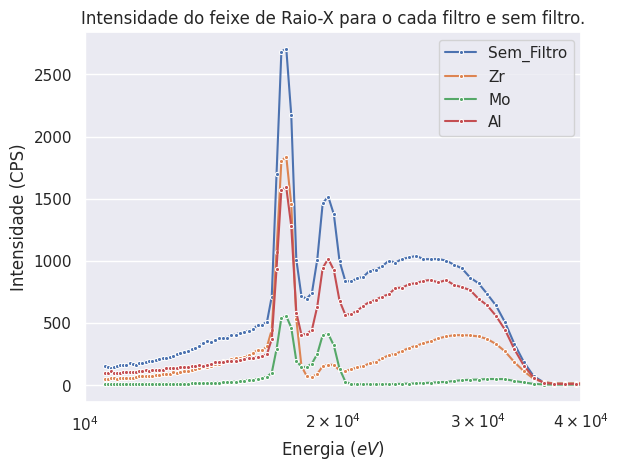

In [13]:
plt.title('Intensidade do feixe de Raio-X para o cada filtro e sem filtro.')
for col in cols: sns.lineplot(data=df['NaCl'], x='Energia', y=col, label=col, marker='.')
plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(10000, 40000)
plt.legend()
plt.xscale('log')
plt.savefig('nacl_absorption.png', dpi=300, bbox_inches='tight')
plt.plot()

In [14]:
df['NaCl']['Absortancia_Zr'] = df['NaCl']['Sem_Filtro'] / df['NaCl']['Zr']
df['NaCl']['Absortancia_Mo'] = df['NaCl']['Sem_Filtro'] / df['NaCl']['Mo']
df['NaCl']['Absortancia_Al'] = df['NaCl']['Sem_Filtro'] / df['NaCl']['Al']

In [15]:
df['NaCl']['sAbsortancia_Zr'] = np.sqrt( (df['NaCl']['sSem_Filtro']/df['NaCl']['Zr'])**2 + ( df['NaCl']['Sem_Filtro'] * df['NaCl']['sZr'] / df['NaCl']['Zr']**2 )**2 )
df['NaCl']['sAbsortancia_Mo'] = np.sqrt( (df['NaCl']['sSem_Filtro']/df['NaCl']['Mo'])**2 + ( df['NaCl']['Sem_Filtro'] * df['NaCl']['sMo'] / df['NaCl']['Mo']**2 )**2 )
df['NaCl']['sAbsortancia_Al'] = np.sqrt( (df['NaCl']['sSem_Filtro']/df['NaCl']['Al'])**2 + ( df['NaCl']['Sem_Filtro'] * df['NaCl']['sAl'] / df['NaCl']['Al']**2 )**2 )

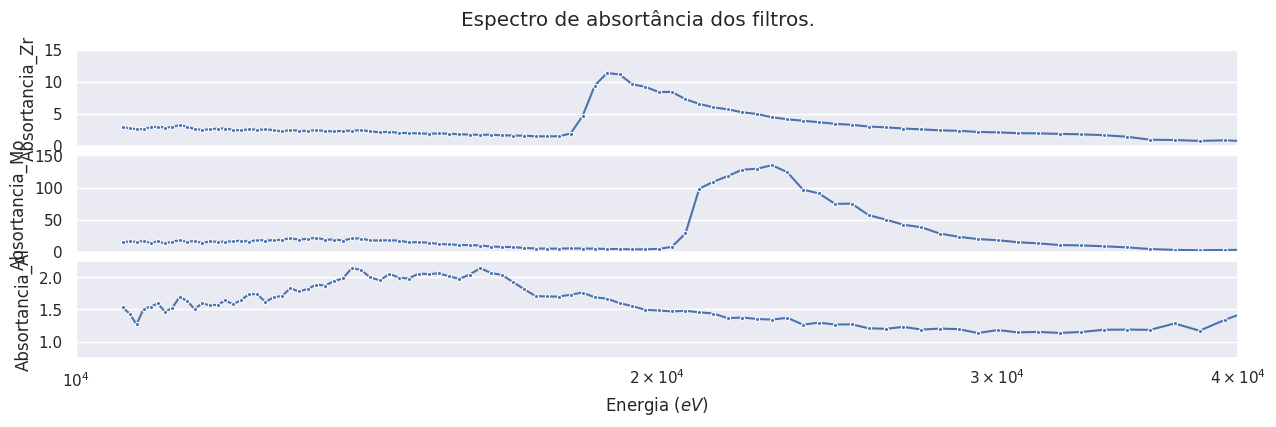

In [30]:
figs, axs = plt.subplots(3, sharex=True, figsize=(15,4), gridspec_kw={ 'hspace': 0.1 })
plt.suptitle('Espectro de absortância dos filtros.')

ylims = ((0, 15), (0, 150), (0.75, 2.25))
for i,col in enumerate(cols[1:]):
  sns.lineplot(data=df['NaCl'], x='Energia', y=f'Absortancia_{col}', marker='.', ax=axs[i])
  axs[i].set_ylim(ylims[i])

plt.xlabel('Energia ($eV$)')
plt.xlim(10000, 40000)
plt.xscale('log')

plt.savefig('nacl_abs_filtes.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
def exponential(x, H, A, a, b): return H + A * np.exp(a * x + b)

In [18]:
p0s   = (
  (0, 70, -1.1E-4, 0),
  (0, 100000, -2.9E-4, 0),
  (0, 2.3, -2.5E-5, 0)
)
ranges = ([ 15, 38 ], [ 15, 31 ], [ 15, 41 ])
fits  = [ [], [], [] ]

In [19]:
for i in range(3):
  fits[i] = curve_fit(
      exponential,
      xdata=df['NaCl']['Energia'][ranges[i][0]:ranges[i][1]],
      ydata=df['NaCl'][f'Absortancia_{cols[i+1]}'][ranges[i][0]:ranges[i][1]],
      p0=p0s[i]
  )

In [32]:
borders = { 'Zr': 0.0, 'Mo': 0.0, 'Al': 0.0 }

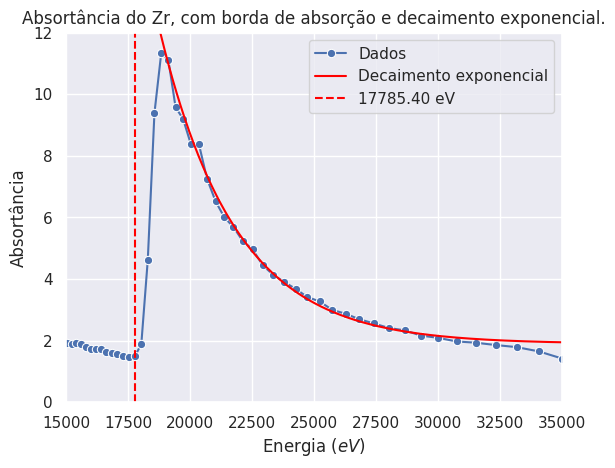

In [50]:
plt.title('Absortância do Zr, com borda de absorção e decaimento exponencial.')

x = np.linspace(18000, 36000, 1000)
sns.lineplot(x=df['NaCl']['Energia'], y=df['NaCl']['Absortancia_Zr'], marker='o', label='Dados')
sns.lineplot(x=x, y=exponential(x, fits[0][0][0], fits[0][0][1], fits[0][0][2], fits[0][0][3]), color='red', label='Decaimento exponencial')

borders['Zr'] = float(df['NaCl']['Energia'][find_peaks(df['NaCl']['Absortancia_Zr'], height=10)[0] + 4])
plt.vlines(x=borders['Zr'], ymin=0, ymax=12, color='red', linestyle='--', label=f'{borders["Zr"]:.2f} eV')

plt.xlim(15000, 35000)
plt.ylim(0, 12)
plt.xlabel('Energia ($eV$)')
plt.ylabel('Absortância')
plt.legend()
plt.show()

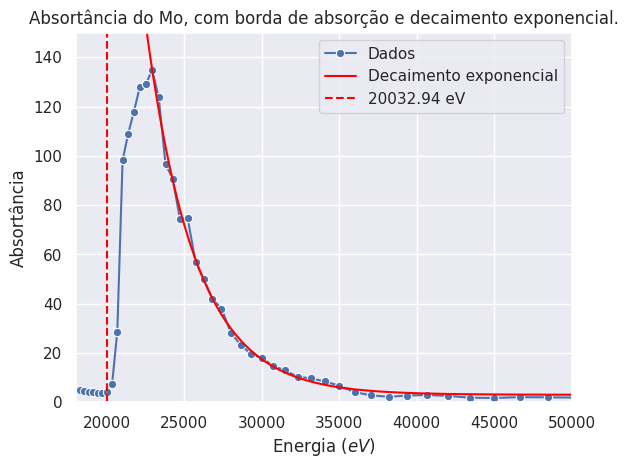

In [54]:
plt.title('Absortância do Mo, com borda de absorção e decaimento exponencial.')

x = np.linspace(18000, 50000, 1000)
sns.lineplot(x=df['NaCl']['Energia'], y=df['NaCl']['Absortancia_Mo'], marker='o', label='Dados')
sns.lineplot(x=x, y=exponential(x, fits[1][0][0], fits[1][0][1], fits[1][0][2], fits[1][0][3]), color='red', label='Decaimento exponencial')

borders['Mo'] = float(df['NaCl']['Energia'][find_peaks(df['NaCl']['Absortancia_Mo'], height=100)[0] + 8])
plt.vlines(x=borders['Mo'], ymin=0, ymax=150, color='red', linestyle='--', label=f'{borders["Mo"]:.2f} eV')

plt.xlim(18000, 50000)
plt.ylim(0, 150)
plt.xlabel('Energia ($eV$)')
plt.ylabel('Absortância')
plt.legend()
plt.show()

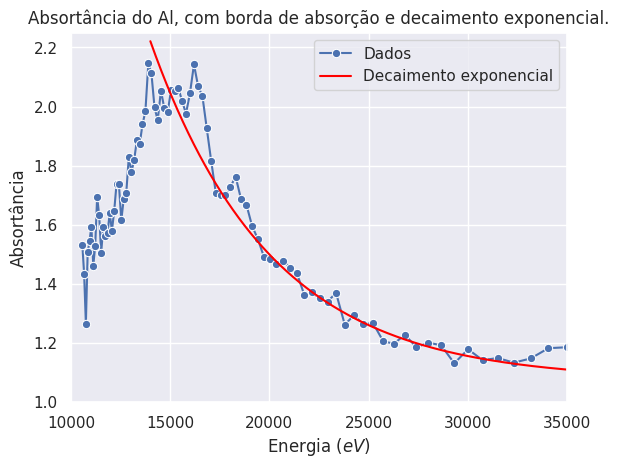

In [22]:
plt.title('Absortância do Al, com borda de absorção e decaimento exponencial.')

x = np.linspace(14000, 35000, 1000)
sns.lineplot(x=df['NaCl']['Energia'], y=df['NaCl']['Absortancia_Al'], marker='o', label='Dados')
sns.lineplot(x=x, y=exponential(x, fits[2][0][0], fits[2][0][1], fits[2][0][2], fits[2][0][3]), color='red', label='Decaimento exponencial')

borders['Mo'] = float(df['NaCl']['Energia'][find_peaks(df['NaCl']['Absortancia_Mo'], height=100)[0] + 8])
plt.vlines(x=borders['Mo'], ymin=0, ymax=150, color='red', linestyle='--', label=f'{borders["Mo"]:.2f} eV')

plt.xlim(10000, 35000)
plt.ylim(1, 2.25)
plt.xlabel('Energia ($eV$)')
plt.ylabel('Absortância')
plt.legend()
plt.show()

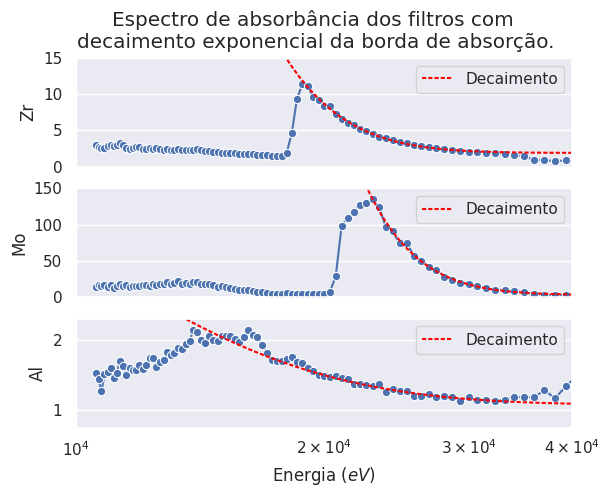

In [23]:
figs, axs = plt.subplots(3, sharex=True, gridspec_kw={ 'hspace': 0.2 })
plt.suptitle('Espectro de absorbância dos filtros com \ndecaimento exponencial da borda de absorção.')

x = np.linspace(10000, 40000, 1000)

ylims = ((0, 15), (0, 150), (0.75, 2.3))
for i,col in enumerate(cols[1:]):
  sns.lineplot(data=df['NaCl'], x='Energia', y=f'Absortancia_{col}', marker='o', ax=axs[i])
  sns.lineplot(x=x, y=exponential(x, fits[i][0][0], fits[i][0][1], fits[i][0][2], fits[i][0][3]), dashes=(2,1), color='red', label='Decaimento', ax=axs[i])
  axs[i].set_ylim(ylims[i])

plt.xlabel('Energia ($eV$)')
plt.xlim(10000, 40000)
plt.xscale('log')

axs[0].set_ylabel('Zr')
axs[1].set_ylabel('Mo')
axs[2].set_ylabel('Al')

plt.savefig('nacl_abs_filtes.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
for i in range(3):
  print(fits[i][0])

[ 1.89591026e+00  2.02880291e+02 -3.27138289e-04  3.15147159e+00]
[ 3.03211167e+00  1.10589488e+05 -3.12944451e-04  4.46933097e-01]
[ 1.07493403e+00  2.79082706e+00 -1.65361089e-04  1.42502822e+00]


### $KBr$ - Brometo de Potássio

In [25]:
df['KBr'] = pd.read_csv('kbr.csv')

In [26]:
df['KBr']['Wavelength'] = lattice['KBr'] * np.sin(np.radians(df['KBr']['Beta']))
df['KBr']['Energia'] = h * c / df['KBr']['Wavelength']

[]

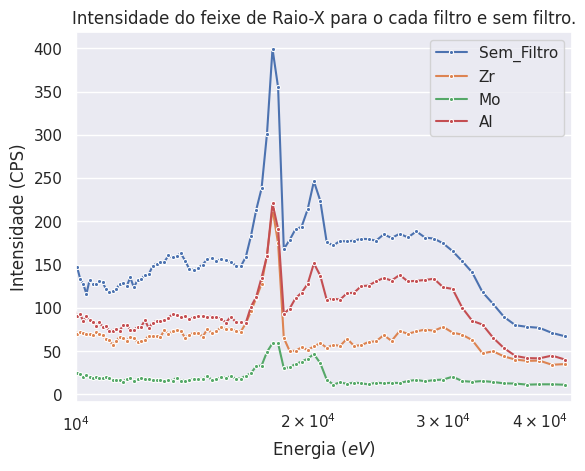

In [27]:
plt.title('Intensidade do feixe de Raio-X para o cada filtro e sem filtro.')
for col in cols: sns.lineplot(data=df['KBr'], x='Energia', y=col, label=col, marker='.')
plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(10000, 44000)
plt.legend()
plt.xscale('log')
plt.savefig('kbr_absorption.png', dpi=300, bbox_inches='tight')
plt.plot()

In [28]:
df['KBr']['Absortancia_Zr'] = df['KBr']['Sem_Filtro'] / df['KBr']['Zr']
df['KBr']['Absortancia_Mo'] = df['KBr']['Sem_Filtro'] / df['KBr']['Mo']
df['KBr']['Absortancia_Al'] = df['KBr']['Sem_Filtro'] / df['KBr']['Al']

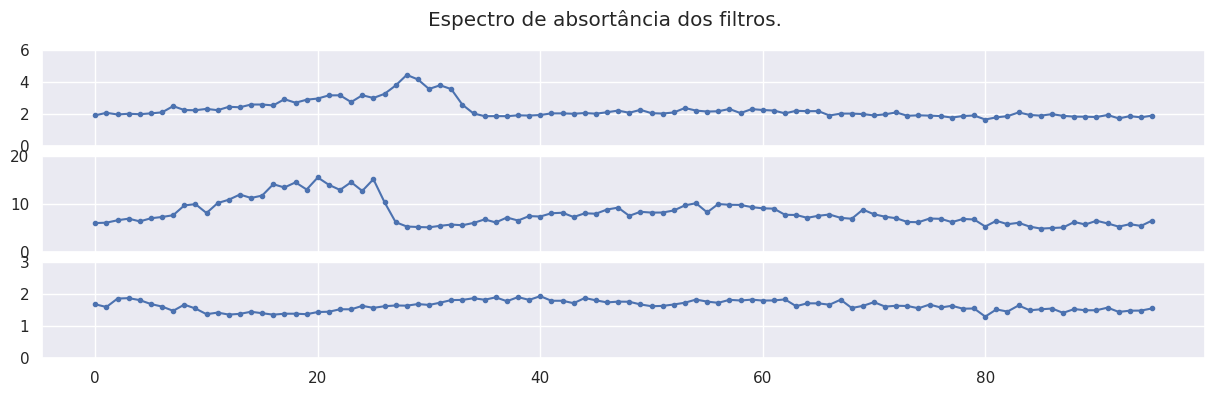

In [29]:
figs, axs = plt.subplots(3, sharex=True, figsize=(15,4), gridspec_kw={ 'hspace': 0.1 })
plt.suptitle('Espectro de absortância dos filtros.')

ylims = ((0, 6), (0, 20), (0, 3))
for i,col in enumerate(cols[1:]):
  axs[i].plot(df['KBr'][f'Absortancia_{col}'], marker='.')
  axs[i].set_ylim(ylims[i])

plt.show()

In [ ]:
p0s   = (
  (0, 70, -1.1E-4, 0),
  (0, 100000, -2.9E-4, 0),
  (0, 2.3, -2.5E-5, 0)
)
ranges = ([ 0, 28 ], [ 0, 25 ], [ 15, 41 ])
fits  = [ [], [], [] ]

In [ ]:
for i in range(3):
  fits[i] = curve_fit(
      exponential,
      xdata=df['KBr']['Energia'][ranges[i][0]:ranges[i][1]],
      ydata=df['KBr'][f'Absortancia {cols[i+1]}'][ranges[i][0]:ranges[i][1]],
      p0=p0s[i]
  )

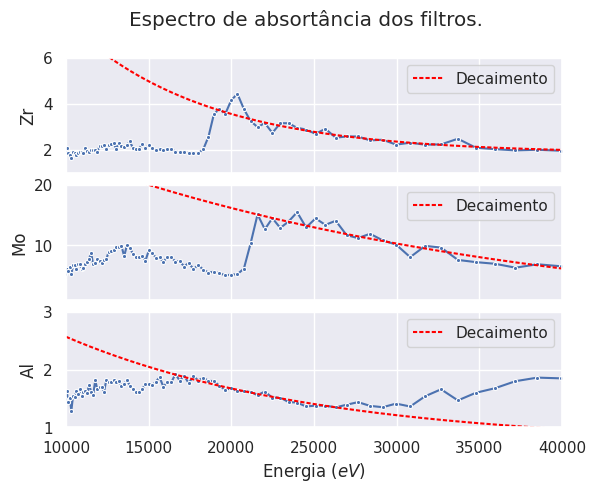

In [ ]:
figs, axs = plt.subplots(3, sharex=True, gridspec_kw={ 'hspace': 0.1 })
plt.suptitle('Espectro de absortância dos filtros.')

x = np.linspace(10000, 40000, 1000)

ylims = ((1, 6), (1, 20), (1, 3))
for i,col in enumerate(cols[1:]):
  sns.lineplot(data=df['KBr'], x='Energia', y=f'Absortancia {col}', marker='.', ax=axs[i])
  sns.lineplot(x=x, y=exponential(x, fits[i][0][0], fits[i][0][1], fits[i][0][2], fits[i][0][3]), dashes=(2,1), color='red', label='Decaimento', ax=axs[i])
  axs[i].set_ylim(ylims[i])

axs[0].set_ylabel('Zr')
axs[1].set_ylabel('Mo')
axs[2].set_ylabel('Al')

plt.xlabel('Energia ($eV$)')
plt.xlim(10000, 40000)

plt.savefig('kbr_abs_filter.png', dpi=300, bbox_inches='tight')
plt.show()

## Estimativa da espessura do filtro

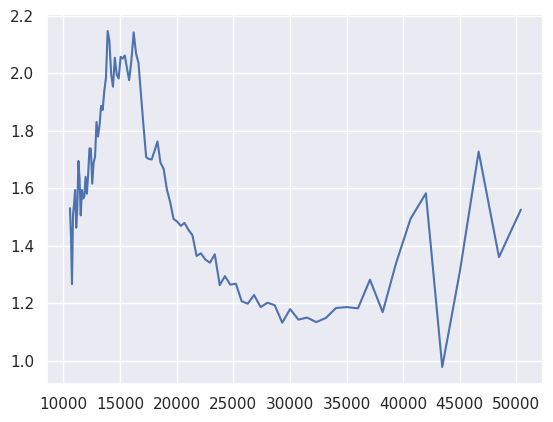

In [ ]:
plt.plot(df['NaCl']['Energia'], df['NaCl']['Absortancia_Al'])
plt.show()

In [ ]:
x = np.linspace(14000, 35000, 1000)
y = exponential(x, fits[2][0][0], fits[2][0][1], fits[2][0][2], fits[2][0][3])
plt.plot(x, np.log(y) / attenuation['Al'](x))
plt.plot()

NameError: ignored